# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder after tomorrows close som target   

In [51]:
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import pickle
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
plt.style.use('fivethirtyeight')
pd.set_option('display.width',200)


<AxesSubplot:xlabel='date'>

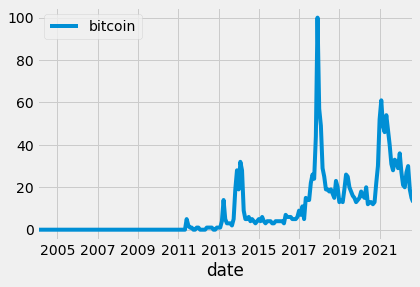

In [160]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(
    kw_list=['bitcoin'], timeframe='all', gprop='news')
df_trend = pytrends.interest_over_time()
df_trend.plot()


In [164]:
df_trend = df_trend[['bitcoin']]
display(df_trend.tail())
# resmaple to daily and spread out the values
(df_trend.resample('D').ffill())


,bitcoin
date,
2022-05-01,27
2022-06-01,30
2022-07-01,19
2022-08-01,15
2022-09-01,13


,bitcoin
date,
2004-01-01,0
2004-01-02,0
2004-01-03,0
2004-01-04,0
2004-01-05,0
...,...
2022-08-28,15
2022-08-29,15
2022-08-30,15


## skapa alla modellerna

In [54]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']

In [55]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [56]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [57]:
display(df_org.isna().sum())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

(2933, 5)

In [93]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



In [94]:
def backtest(data, target, model, predictors, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = fit_predict(
            train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [95]:
def new_features(df_, ticker, target):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    horizons = [2, 5, 60, 250]
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, 1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        trend_column = f"Trend_{horizon}"
        df[trend_column] = df.shift(1).rolling(horizon, 1).sum()[target]

        new_predictors += [ratio_column, trend_column]

    new_predictors.append('stoch_k')
    df = df.dropna()
    return df, new_predictors


In [96]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
print(tickers[0])
df, new_predictors = new_features(df_org, tickers[0], 'y1')
df[new_predictors+['y1']]


BTC-USD


,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,y1
Date,,,,,,,,,,
2017-11-10,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.1433,0
2017-11-11,0.9799,0.0,0.9480,0.0,0.9480,0.0,0.9480,0.0,0.0000,0
2017-11-12,0.9669,0.0,0.9130,0.0,0.9130,0.0,0.9130,0.0,0.0000,1
2017-11-13,1.0487,1.0,1.0052,1.0,1.0052,1.0,1.0052,1.0,0.0914,1
2017-11-14,1.0058,2.0,1.0329,2.0,1.0140,2.0,1.0140,2.0,0.1926,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-21,0.9908,0.0,0.9607,2.0,0.8580,27.0,0.5912,120.0,0.0183,1
2022-09-22,1.0228,1.0,1.0131,2.0,0.9003,27.0,0.6207,120.0,0.2920,0
2022-09-23,0.9970,1.0,1.0083,2.0,0.8963,27.0,0.6189,120.0,0.5556,0


### Vi använder XGBoost

In [97]:
xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_params, random_state=2022, n_jobs=-1)

predictions_xgb = backtest(df, 'y1', xgb, new_predictors, proba_val= 0.6, step=30)
xgb_try = print_results(predictions_xgb,'y1')

pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False)

Fördelning av y1: 1 vs 0:
1    0.5178
0    0.4822
Name: y1, dtype: float64
y1  Predictions
1   0              676
0   0              630
1   1               51
0   1               47
dtype: int64
Precision:	0.5204


,importance
Trend_5,0.1172
Close_Ratio_60,0.1171
Close_Ratio_2,0.1169
Close_Ratio_5,0.1139
Close_Ratio_250,0.1121
stoch_k,0.1117
Trend_60,0.1059
Trend_250,0.1053
Trend_2,0.0999


In [98]:
df

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,stoch_k,Tomorrow,After_tomorrow,y1,y2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,,,
2017-11-10,6618.1401,299.2530,1007.4200,0.1972,0.2065,0.1433,6357.6001,5950.0698,0,0,0.9618,0.0,0.9618,0.0,0.9618,0.0,0.9618,0.0
2017-11-11,6357.6001,314.6810,1340.4500,0.1972,0.2104,0.0000,5950.0698,6559.4902,0,1,0.9799,0.0,0.9480,0.0,0.9480,0.0,0.9480,0.0
2017-11-12,5950.0698,307.9080,1388.8600,0.1879,0.1973,0.0000,6559.4902,6635.7500,1,1,0.9669,0.0,0.9130,0.0,0.9130,0.0,0.9130,0.0
2017-11-13,6559.4902,316.7160,1353.9900,0.1969,0.2034,0.0914,6635.7500,7315.5400,1,1,1.0487,1.0,1.0052,1.0,1.0052,1.0,1.0052,1.0
2017-11-14,6635.7500,337.6310,1273.5300,0.1993,0.2098,0.1926,7315.5400,7871.6899,1,1,1.0058,2.0,1.0329,2.0,1.0140,2.0,1.0140,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-21,18547.4004,1252.6078,109.4631,0.2601,0.3968,0.0183,19413.5508,19297.6387,1,1,0.9908,0.0,0.9607,2.0,0.8580,27.0,0.5912,120.0
2022-09-22,19413.5508,1327.6802,116.5392,0.2764,0.4851,0.2920,19297.6387,18937.0117,0,0,1.0228,1.0,1.0131,2.0,0.9003,27.0,0.6207,120.0
2022-09-23,19297.6387,1328.2595,120.0612,0.2788,0.5072,0.5556,18937.0117,18802.0977,0,0,0.9970,1.0,1.0083,2.0,0.8963,27.0,0.6189,120.0


Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker (= 10 st)    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [100]:
for ticker in tickers:
    namn = ticker[:3]
    print(namn)
    df, new_predictors = new_features(df_org, ticker, 'y1')
    predictions_xgb = backtest(df, 'y1', xgb, new_predictors, proba_val= 0.6, step=30)
    xgb_try = print_results(predictions_xgb,'y1')
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    xgb.fit(df[new_predictors], df['y1'])
    # pickle dump model
    pickle.dump(xgb, open(f'{namn}_y1.pkl', 'wb'))
    
    df, new_predictors = new_features(df_org, ticker, 'y2')
    predictions_xgb = backtest(df, 'y2', xgb, new_predictors, proba_val= 0.6, step=30)
    xgb_try = print_results(predictions_xgb,'y2')
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    xgb.fit(df[new_predictors], df['y2'])
    # pickle dump model
    pickle.dump(xgb, open(f'{namn}_y2.pkl', 'wb'))
    
    

BTC
Fördelning av y1: 1 vs 0:
1    0.5178
0    0.4822
Name: y1, dtype: float64
y1  Predictions
1   0              676
0   0              630
1   1               51
0   1               47
dtype: int64
Precision:	0.5204


,importance
Trend_5,0.1172
Close_Ratio_60,0.1171
Close_Ratio_2,0.1169
Close_Ratio_5,0.1139
Close_Ratio_250,0.1121
stoch_k,0.1117
Trend_60,0.1059
Trend_250,0.1053
Trend_2,0.0999


Fördelning av y2: 1 vs 0:
1    0.5285
0    0.4715
Name: y2, dtype: float64
y2  Predictions
0   0              579
1   0              559
    1              183
0   1               83
dtype: int64
Precision:	0.6880


,importance
Trend_2,0.2595
Close_Ratio_5,0.1098
Trend_5,0.1023
Close_Ratio_2,0.0993
Close_Ratio_60,0.0928
Trend_60,0.0884
stoch_k,0.0855
Close_Ratio_250,0.0847
Trend_250,0.0778


ETH
Fördelning av y1: 1 vs 0:
1    0.5189
0    0.4811
Name: y1, dtype: float64
y1  Predictions
1   0              689
0   0              650
1   1               38
0   1               24
dtype: int64
Precision:	0.6129


,importance
Close_Ratio_2,0.1255
Close_Ratio_5,0.1172
stoch_k,0.1152
Close_Ratio_250,0.1118
Close_Ratio_60,0.1116
Trend_5,0.1088
Trend_250,0.1065
Trend_60,0.1052
Trend_2,0.0982


Fördelning av y2: 1 vs 0:
1    0.5218
0    0.4782
Name: y2, dtype: float64
y2  Predictions
0   0              622
1   0              584
    1              147
0   1               48
dtype: int64
Precision:	0.7538


,importance
Trend_2,0.2459
Close_Ratio_2,0.1202
Close_Ratio_5,0.1090
Trend_5,0.0891
Close_Ratio_250,0.0885
Close_Ratio_60,0.0883
Trend_250,0.0874
Trend_60,0.0865
stoch_k,0.0851


BCH
Fördelning av y1: 1 vs 0:
0    0.51
1    0.49
Name: y1, dtype: float64
y1  Predictions
0   0              697
1   0              675
0   1               16
1   1               10
dtype: int64
Precision:	0.3846


,importance
Close_Ratio_2,0.1249
Close_Ratio_5,0.1179
Trend_2,0.1178
Close_Ratio_250,0.1158
stoch_k,0.1082
Close_Ratio_60,0.1059
Trend_250,0.1058
Trend_5,0.1039
Trend_60,0.0999


Fördelning av y2: 1 vs 0:
0    0.5165
1    0.4835
Name: y2, dtype: float64
y2  Predictions
0   0              674
1   0              555
    1              121
0   1               48
dtype: int64
Precision:	0.7160


,importance
Trend_2,0.2597
Close_Ratio_2,0.1246
Close_Ratio_5,0.1158
stoch_k,0.0856
Close_Ratio_250,0.0842
Trend_60,0.0839
Trend_5,0.0827
Trend_250,0.0824
Close_Ratio_60,0.0810


ZRX
Fördelning av y1: 1 vs 0:
0    0.5057
1    0.4943
Name: y1, dtype: float64
y1  Predictions
0   0              697
1   0              682
0   1               11
1   1               10
dtype: int64
Precision:	0.4762


,importance
Close_Ratio_2,0.1182
Close_Ratio_60,0.1149
stoch_k,0.1129
Trend_60,0.1127
Close_Ratio_5,0.1121
Trend_2,0.1092
Close_Ratio_250,0.1089
Trend_250,0.1078
Trend_5,0.1033


Fördelning av y2: 1 vs 0:
0    0.5257
1    0.4743
Name: y2, dtype: float64
y2  Predictions
0   0              712
1   0              604
    1               60
0   1               24
dtype: int64
Precision:	0.7143


,importance
Trend_2,0.2292
Trend_5,0.1236
Close_Ratio_2,0.1106
Close_Ratio_5,0.1067
Close_Ratio_250,0.0927
Trend_250,0.0885
stoch_k,0.0850
Trend_60,0.0821
Close_Ratio_60,0.0816


XRP
Fördelning av y1: 1 vs 0:
0    0.5061
1    0.4939
Name: y1, dtype: float64
y1  Predictions
0   0              692
1   0              662
    1               30
0   1               17
dtype: int64
Precision:	0.6383


,importance
Close_Ratio_2,0.1301
Close_Ratio_250,0.1134
Close_Ratio_5,0.1127
Close_Ratio_60,0.1118
Trend_2,0.1091
Trend_60,0.1075
stoch_k,0.1074
Trend_250,0.1061
Trend_5,0.1020


Fördelning av y2: 1 vs 0:
0    0.5261
1    0.4739
Name: y2, dtype: float64
y2  Predictions
0   0              710
1   0              604
    1               60
0   1               27
dtype: int64
Precision:	0.6897


,importance
Trend_2,0.2365
Close_Ratio_2,0.1217
Close_Ratio_5,0.1120
Trend_5,0.0979
Close_Ratio_60,0.0953
stoch_k,0.0889
Close_Ratio_250,0.0853
Trend_250,0.0837
Trend_60,0.0787
